### SVM（支持向量机）  
#### 1.核心目标：  
找到一个能够最大化两个类别之间边缘的超平面，在所有可行的决策边界中，SVM选择可以使两类样本距离边界最远的超平面，确保模型具有良好的泛化性能  
- 超平面：在线性情况下，决策边界数学表示为$$w^T\cdot x+b=0$$  
- 支持向量：数据集中距离决策边界最近的样本点，直接决定了最优超平面的位置  


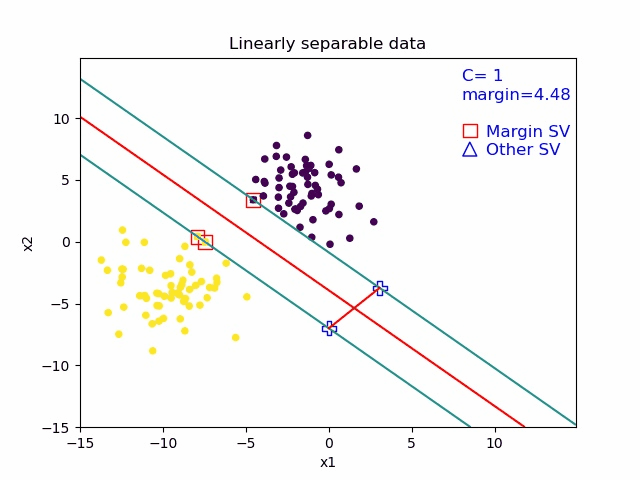

#### 2.间隔  
- 函数间隔：定义为$y(w^Tx+b)$,用于衡量分类的正确性和置信度  
- 几何间隔：是样本点到决策边界的实际欧式距离，SVM的优化本质就是最大化最小集合间隔 

#### 3.线性可分与优化  
对于线性可分的数据集，SVM通过求解一个凸优化问题来确定参数  
- 优化目标：数学上等同于最大化几何间隔，即最小化$$1/2 ||w||^2$$
- 约束条件：确保每个样本i都满足$$1 - y_i(w^T x_i + b) \leq 0$$

#### 4.核技巧与高维映射  
当数据在原始空间中线性不可分时，SVM使用和函数将数据映射到高维特征空间中，使其变得线性可分  
- 核心优势：核技巧允许算法在不显示计算高维特征向量的情况下，通过计算内积来完成学习过程，节省了计算资源  
- 常用和函数：线性核，多项式核，高斯核

#### 5.软间隔与正则化  
为了处理现实数据中的噪声和离群点  
- 松弛变量：允许某些样本不满足严格的间隔约束  
- 惩罚系数：一个超参数，用于增大边缘和减少训练误差之间进行权衡。较大的C会迫使模型尽量正确分类所有训练点，可能导致过拟合；较小的C则允许更大的间隔，提高稳健性

#### 叽里咕噜说了一大堆，其实SVM用数学推导一遍就是一个凸优化问题，数学推导后期更新。接下来直接直观进行代码实现。在此之前先介绍一下SVM包含的超参数

#### 6.需要寻优的超参数  
- 惩罚系数C：用于平衡“最大化分类间隔“和”减少训练样本的错误分类“  
影响：较大的C值会对误分类施加更大的惩罚，迫使模型尝试正确分类所有训练点。较小的C值则允许模型忽略一些异常点货噪声  
- 核函数类型：依据数据分布特征来选取线性核和高斯核。对于不同的核函数还需要选择不同的参数  
- 松弛变量：处理不可分数据，则引入松弛变量，将数据点映射到高维空间，并使用高维数据进行分类


#### 7.实验数据介绍  
- 这里用到的数据集合是某电商平台的评论数据（10000条，有一条出现异常）  
- 其中评论的情感已经做好了处理（0为好评，1为差评）
- 数据的预处理包含文本转换词向量（该部分内容可能会在后期更新深度学习教程详细介绍，此处不用掌握）  
- 需要的数据还有哈工大的停用词词库
- 所有数据都在本文件夹下的data中  
- 同时，为了比较后面几个分类算法的运用。后面分类任务运用的数据也用该数据集

In [80]:
import pandas as pd 
import numpy as np 
import jieba 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec

In [81]:
df = pd.read_csv(
    r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\comments_data.csv',
    encoding='gbk'
)
print(df.head())
print(f'评论总数量：{len(df["comments"])}')

                                            comments  sentiment
0  买来用做PS和Pr等，性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，视网膜屏...          0
1  按事情音质非常不错！屏幕分辨率焕然一新！第一次入手苹果生态！感觉好极了。键盘也很耐用爱了爱了...          0
2  性能非常强大，外观非常好看，很轻很薄，界面颜色很好看，很流畅，可以做多用途，京东自营肯定有正...          0
3  运行速度：非常快，屏幕效果：显示很细腻很爽啊！，散热性能：散热效果非常棒，外形外观：深空灰很...          0
4  很流畅，用的很舒服，音质真的强，运行速度：很快，屏幕效果：Nice，散热性能：比intel版...          0
评论总数量：10000


In [ ]:
# 提取特征和标签
df = df[df['comments'].notna() & (df['comments'] != '')].reset_index(drop=True)  # 过滤空评论
X_raw = df['comments']  # 原始评论文本
y = df['sentiment']     # 标签（情感值）
print(f'过滤后有效评论数：{len(X_raw)}，标签数：{len(y)}')
print('前5个标签：\n', y.head())

过滤后有效评论数：10000，标签数：10000
前5个标签：
 0    0
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64


In [83]:
# 对评论内容进行分词
all_words = []
for sentence in X_raw:
    if sentence and isinstance(sentence, str):  # 确保是有效字符串
        words = jieba.lcut(sentence)
        all_words.append(words)
    else:
        all_words.append([])  # 空评论赋值空列表，保持样本数一致
print('第一条评论分词结果：', all_words[0])
print('完成分词')


第一条评论分词结果： ['买来', '用做', 'PS', '和', 'Pr', '等', '，', '性能', '非常', '强大', '，', '外观', '非常', '好看', '，', '很轻', '很', '薄', '，', '界面', '颜色', '很', '好看', '，', '很', '流畅', '，', '视网膜', '屏幕', '很', '不错', '，', '很', '舒适', '，', '比', '一般', '的', 'IPS', '屏幕', '好', '很多', '，', '散热', '很', '好']
完成分词


In [84]:
# 去除停用词
stopwords_file = r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\stopwords.txt'
# 按行读取停用词，过滤空行（避免停用词列表包含空字符串）
with open(stopwords_file, 'r', encoding='UTF-8') as fp:
    stop_words = [word.strip() for word in fp.read().split('\n') if word.strip() != '']
print('前100个停用词：\n', stop_words[0:100])

# 对每条评论去除停用词和空字符串
for idx in range(len(all_words)):
    all_words[idx] = [
        word for word in all_words[idx] 
        if word not in stop_words and word.strip() != ''
    ]
print('第一条评论去停用词后结果：', all_words[0])
print('完成去停用词')


前100个停用词：
 ['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '万一', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '也', '也好', '也罢', '了', '二来', '于', '于是', '于是乎']
第一条评论去停用词后结果： ['买来', '用做', 'PS', 'Pr', '性能', '强大', '外观', '好看', '很轻', '薄', '界面', '颜色', '好看', '流畅', '视网膜', '屏幕', '不错', '舒适', 'IPS', '屏幕', '散热']
完成去停用词


第一条评论分词后的结果是：  

['买来', '用做', 'PS', '和', 'Pr', '等', '，', '性能', '非常', '强大', '，', '外观', '非常', '好看', '，', '很轻', '很', '薄', '，', '界面', '颜色', '很', '好看', '，', '很', '流畅', '，', '视网膜', '屏幕', '很', '不错', '，', '很', '舒适', '，', '比', '一般', '的', 'IPS', '屏幕', '好', '很多', '，', '散热', '很', '好']  
去除停用词后为：  

['买来', '用做', 'PS', 'Pr', '性能', '强大', '外观', '好看', '很轻', '薄', '界面', '颜色', '好看', '流畅', '视网膜', '屏幕', '不错', '舒适', 'IPS', '屏幕', '散热']

In [85]:
# 训练word2vec模型生成词向量，将分词后的评论转换为句向量
word2vec_model = Word2Vec(sentences=all_words, vector_size=100, window=5, min_count=1, workers=4)
# 保存模型
word2vec_model.save(r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\word2vec.model')
print('Word2Vec模型训练并保存完成')


sentences_vector = []
vec_size = word2vec_model.wv.vector_size  # 获取词向量维度
print(f'词向量维度：{vec_size}')

for sentence in all_words:
    sentence_vector = np.zeros(vec_size)  # 初始化空的句向量
    if len(sentence) > 0:  # 避免空评论除以0报错
        word_vectors = [word2vec_model.wv.get_vector(word) for word in sentence]
        sentence_vector = np.sum(word_vectors, axis=0) / len(sentence)  # 求和后取平均
    sentences_vector.append(sentence_vector)

Word2Vec模型训练并保存完成
词向量维度：100


In [86]:
sentences_vector = np.array(sentences_vector)
print('评论转句向量完成，句向量矩阵维度：', sentences_vector.shape)  
print('最后一条评论的句向量前10个值：', sentences_vector[-1][:10])

评论转句向量完成，句向量矩阵维度： (10000, 100)
最后一条评论的句向量前10个值： [-0.15400222  0.5250858   0.09092486 -0.30232486 -0.13292767 -0.4801174
 -0.05214748  0.70720965 -0.04798342 -0.3103991 ]


In [87]:
#划分训练集和测试集
X = sentences_vector  
# 测试集30%，训练集70%，随机种子42保证结果可复现，
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('训练集/测试集划分成功')
print(f'训练集特征维度：{X_train.shape}，训练集标签数量：{y_train.shape}')  
print(f'测试集特征维度：{X_test.shape}，测试集标签数量：{y_test.shape}')  

训练集/测试集划分成功
训练集特征维度：(7000, 100)，训练集标签数量：(7000,)
测试集特征维度：(3000, 100)，测试集标签数量：(3000,)


最优参数是{'gamma': 1, 'C': 1}
支持向量机花费时间53.9395227432251
训练集优度:0.9527142857142857
测试集优度:0.94
预测时间1.0412356853485107


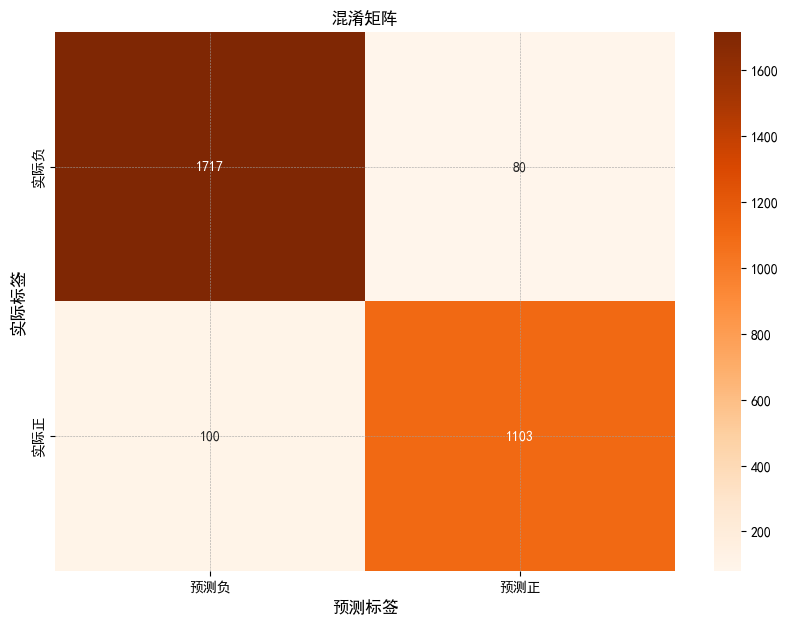

F1 Score:0.9245599329421627


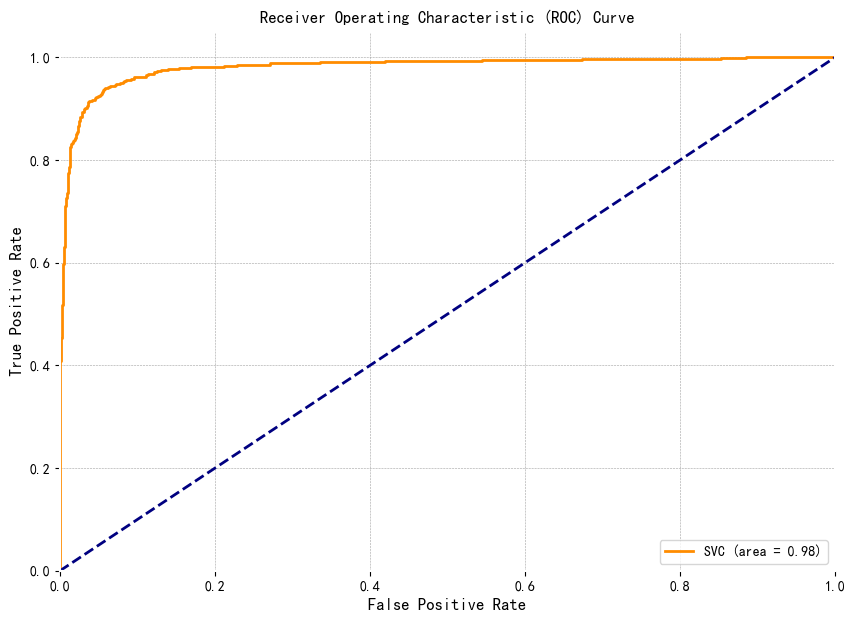

In [88]:
# SVM分类
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import time
start=time.time()
svc=SVC(probability=True)
#参数寻优
param_distributions={'C':[0.1,0.3,1],
            'gamma':[0.1,0.3,1]
            }
random_search = RandomizedSearchCV(svc, param_distributions, n_iter=5, cv=5, random_state=42)
random_search.fit(X_train, y_train)
print('最优参数是{}'.format(random_search.best_params_))
C_best = random_search.best_params_['C']
G = random_search.best_params_['gamma']
svc = SVC(C=C_best, gamma=G,probability=True)
svc.fit(X_train, y_train)
end=time.time()
print('支持向量机花费时间{}'.format(end-start))
start=time.time()
train_score=svc.score(X_train,y_train)
test_score=svc.score(X_test,y_test)
end=time.time()
print('训练集优度:{}'.format(train_score))
print('测试集优度:{}'.format(test_score))
print('预测时间{}'.format(end-start))

#测试评估模型
y_pred=svc.predict(X_test)
#获取混淆矩阵
cm=confusion_matrix(y_test,y_pred)
#绘制
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap='Oranges',xticklabels=['预测负','预测正'],yticklabels=['实际负','实际正'])
plt.xlabel('预测标签')
plt.ylabel('实际标签')
plt.title('混淆矩阵')
plt.show()
#F1 Score
print('F1 Score:{}'.format(f1_score(y_test,y_pred)))
#绘制ROC曲线
svc_pred_prob = svc.predict_proba(X_test)[:,1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_pred_prob)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(10,7))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='SVC (area = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [89]:
#抽取50条进行检验
import random

y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


test_total = len(X_test)
sample_num = 50  # 抽取样本数
# 限制start范围：0 ≤ start ≤ 测试集长度-50，若测试集不足50条，直接取全部
if test_total < sample_num:
    start = 0
    sample_num = test_total
    print(f"测试集仅{test_total}条数据，不足50条，将抽取全部数据测试")
else:
    start = random.randint(0, test_total - sample_num)  # 修正原100-2400的硬编码，适配任意测试集长度

# 抽取50条数据（特征+标签），因已重置索引，切片后样本完全匹配
X_data = X_test[start:start+sample_num]
y_data = y_test[start:start+sample_num]
success_test = 0


for sequence_index in range(len(X_data)):
 
    comment_words = all_words[start + sequence_index]
    # 拼接分词结果输出（处理空评论情况）
    comment_str = '/'.join(comment_words) if comment_words else '【空评论】'
    print(f"评论分词结果：{comment_str}")
    # 模型预测（传入二维数组，适配sklearn要求）
    x_sample = X_data[sequence_index:sequence_index+1]  
    res = svc.predict(x_sample)[0]  # 取预测结果的标量值（0/1）
    # 【关键修正5】标签用数值类型0/1判断，与模型训练/预测结果一致
    # 输出预测结果
    if res == 0:             
        print('Predict result : 好评', end='\t')             
    else:              
        print('Predict result : 差评', end='\t')            
    # 输出实际结果（y_data已重置索引，直接用位置索引访问，数值类型）
    y_actual = y_data.iloc[sequence_index]  # 用iloc确保位置访问，兼容Series
    if y_actual == 0:
        print('Actual results: 好评', end='\t')
    else:   
        print('Actual results: 差评', end='\t')
    # 判断预测是否正确
    if res == y_actual:
        print('Predict success!', end='\t')
        success_test += 1
    else:
        print('Predict fail!', end='\t')
    print('\n' + '-'*80 + '\n')  
# 计算并输出预测准确度
accuracy = success_test / sample_num
print(f'本次支持向量机测试共抽取{sample_num}条数据，预测准确度为: {accuracy:.4f}（{success_test}/{sample_num}）')

评论分词结果：运行/速度/开机/速度/很快/运行/速度/屏幕/效果/14/寸/屏幕/日常/需求/不太/喜欢/太大/屏幕/散热/性能/风扇/吹/刷剧/电影/发热/外形/外观/精致/很漂亮/眼前一亮/感觉/华为/东西/越做越
Predict result : 好评	Actual results: 好评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：纠结/久/最终/选择/这款/快递/快/包装/不错/设置/提示/一步/一步/操作/比较简单/配置/线程/运行/速度/不错/指纹/密码/开机/记不住/密码/新/系统/操作/习惯/慢慢/探索
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：运行/速度/挺/流畅/屏幕/效果/清晰度/高/散热/性能/热/外形/外观/很漂亮/喜欢/款式/高端/大气/上档次
Predict result : 好评	Actual results: 好评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：棒/电脑/i5/20/版/matebook14/爱人/买/这台/颜值/棒/简单/办公/娱乐/正版/office/办公/软件/值得/拥有
Predict result : 差评	Actual results: 差评	Predict success!	
--------------------------------------------------------------------------------

评论分词结果：品质/做工/做工/精细/质量/款式/时尚/大气/满意/购物/轻薄/程度/适合/出差/旅行/外形/外观/简洁/美观/屏幕/效果/显示屏/效果
Predict result : 

### 在随机抽取的50条评论中，仅错了1个例子，说明SVM模型的性能还是不错的。对分类任务的性能判断主要根据以下方法：

#### 7.性能测量  
1. 混淆矩阵：
混淆矩阵是一个二维矩阵，用于展示模型在分类任务中的性能。它的行代表真实类别，列代表模型预测的类别。矩阵中的每个元素表示模型将样本分类为该类别的次数  

在本任务中，混淆矩阵为：

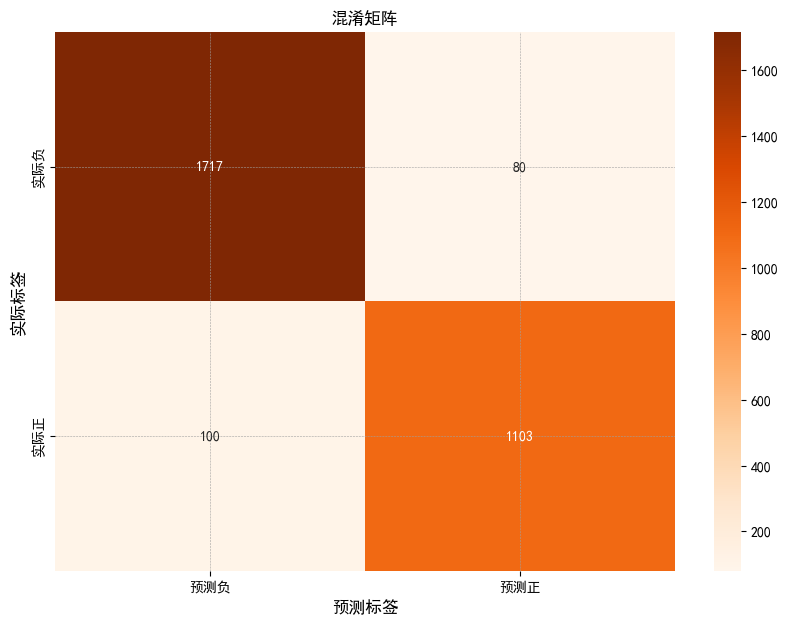

混淆矩阵可以揭示分类的准确率，召回率  
- 准确率：计算公式为$Accuracy = \frac{TP} {TP + FP} $ TP 为真阳数，FP为假阳数
- 召回率：计算公式为$Recall = \frac{TP}{TP + FN}$ TP 为真阳数，FN为假阴数
- 在图中（预测正，实际负）的区块表示FP,在图中（预测负，实际正）的区块表示FN,在图中（预测正，实际正）的区块表示TP,在图中（预测负，实际负）的区块表示TN
- 主要观察FN和FP，如果这两个区块的颜色较浅，说明模型的分类能力较好


2. F1 Score：
  准确率和召回率的调和平均值，用于综合评估模型的分类性能。它的计算公式为$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$，其中Precision为准确率，Recall为召回率

3. ROC曲线：
  用于评估分类模型在不同阈值下的性能。它通过绘制真阳率（True Positive Rate，TPR）对假阳率（False Positive Rate，FPR）的曲线，展示了模型在不同阈值下的分类能力  

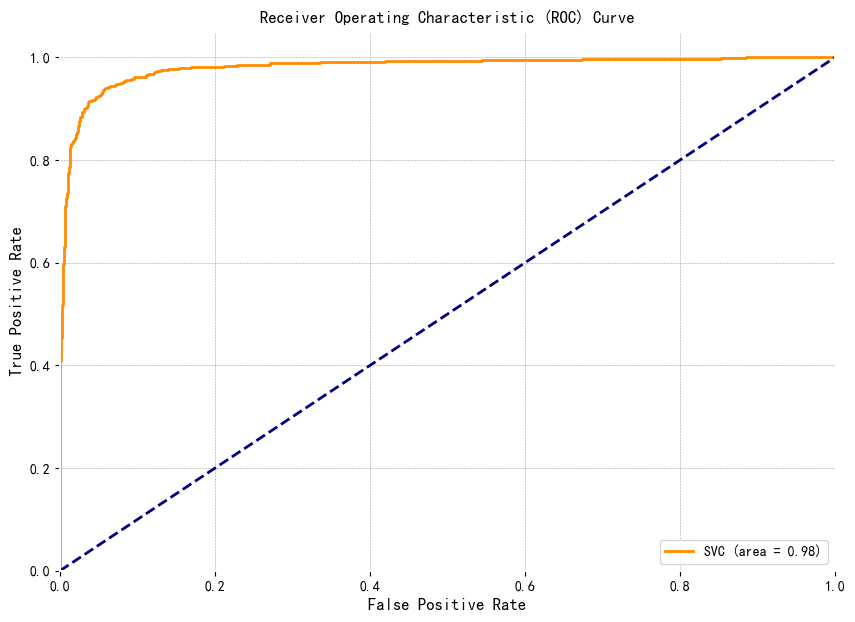

#### 8.SVM回归--SVR

##### SVM回归与分类的区别和联系
- SVM回归和分类模型在本质上采用相同的方法寻找最优超平面。它们的主要区别在于回归模型可以处理连续值的输出，而分类模型处理的是离散的类别标签。

- 模型结构 ：虽然两种模型的模型结构相同，但在回归问题中，SVM需要适应连续的输出值，通过引入松弛变量和不敏感损失函数来实现。

- 损失函数 ：分类问题的SVM使用hinge损失，而回归问题的SVM使用ε-不敏感损失函数。在分类中，错误分类的点会被加入到损失计算中；在回归中，只有当预测值与真实值的差异大于ε时，才会对损失函数产生贡献。

- 支持向量 ：尽管处理方式不同，但两种模型都依赖于支持向量，即那些位于边界附近的点。在回归问题中，支持向量是定义ε-带宽的边界点。



回归任务利用茅台2001-2024年6月的股价数据，包括了开盘价，收盘价，最高价，最低价，成交量，成交额，换手率等6个特征，预测收盘价

In [105]:
import tushare as ts
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
# 解决中文/负号显示问题（关键，避免图表乱码）
plt.rcParams['font.sans-serif'] = [ 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
# 设置全局绘图样式（优化颜值，统一风格）
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'f8f9fa'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.4
import mplfinance as mpf
import warnings 
warnings.filterwarnings('ignore')

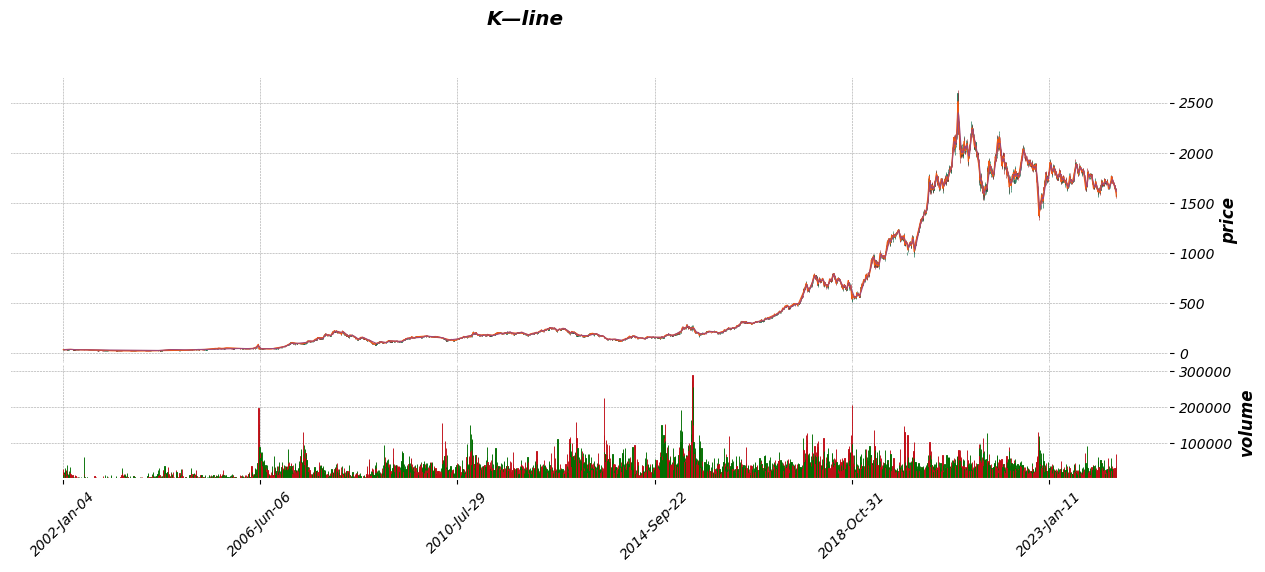

In [91]:
df=pd.read_excel(r'C:\Users\23017\Desktop\Machine Learning\Supervised Learning\data\MaoTai.xlsx')
df.rename(columns={
    'trade_date':'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'vol': 'Volume'  
}, inplace=True)
#转换日期格式
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.sort_index(ascending=True,inplace=True)
#绘制蜡烛图
mpf.plot(df, type='candle', style='charles',
         title='K—line',
         ylabel='price',
         ylabel_lower='volume',
         volume=True,
         figratio=(14,5),
         mav=(3,6,9),
         warn_too_much_data=1000
         
         )  
plt.show()

,Open,Close,Down,Low,High,Volume,Turn,MA5,MA10,RSI,Return
Date,,,,,,,,,,,
2002-01-04,38.72,37.55,-1.00,37.45,38.80,29110,0.0407,NaN,NaN,NaN,NaN
2002-01-07,37.15,37.35,-0.20,36.68,37.50,18943,0.0265,NaN,NaN,NaN,-0.005326
2002-01-08,37.00,36.59,-0.76,36.48,37.59,13287,0.0186,NaN,NaN,NaN,-0.020348
2002-01-09,36.50,36.87,0.28,36.35,37.18,10607,0.0148,NaN,NaN,NaN,0.007652
2002-01-10,36.98,37.24,0.37,36.35,37.39,18816,0.0263,37.120,NaN,NaN,0.010035
2002-01-11,37.01,36.05,-1.19,36.00,37.14,11835,0.0166,36.820,NaN,NaN,-0.031955
2002-01-14,35.70,36.10,0.05,35.43,36.40,18719,0.0262,36.570,NaN,NaN,0.001387
2002-01-15,35.98,36.54,0.44,35.91,37.05,18247,0.0255,36.560,NaN,NaN,0.012188
2002-01-16,36.48,36.35,-0.19,35.40,36.97,13974,0.0195,36.456,NaN,NaN,-0.005200


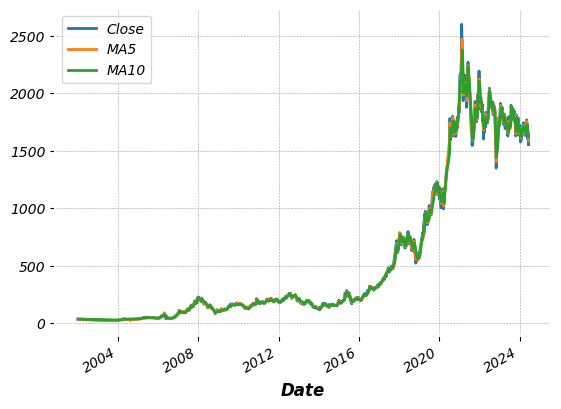

In [ ]:
#构造技术指标
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
#构造RSI：相对强弱指标
df['RSI'] = (df['Close'] - df['Close'].rolling(window=14).min()) / (df['Close'].rolling(window=14).max() - df['Close'].rolling(window=14).min())
#构造回报率
df['Return'] = df['Close'] .pct_change()
df[['Close', 'MA5', 'MA10']].plot()
df.head(10)

In [99]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # 标准化工具
from sklearn.model_selection import GridSearchCV
#目标变量：预测未来5天的收盘价
df['target']=df['Close'].shift(-5)
df = df.dropna()
X = df[['Open', 'High', 'Low', 'Down','Volume', 'Turn','MA5', 'MA10', 'RSI', 'Return']]
y = df['target']
# 时序划分：取最后5个样本为「未来5天真实数据」，前序为训练测试集（禁止随机打乱）
future_5_X = X.iloc[-5:]    # 未来5天特征（真实）
future_5_y_true = y.iloc[-5:]# 未来5天收盘价真实值（用于对比）
X_train_test = X.iloc[:-5]  # 训练+测试集特征
y_train_test = y.iloc[:-5]  # 训练+测试集目标值

# 划分训练集(80%)和测试集(20%)，shuffle=False保证时序连续性
X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, test_size=0.2, random_state=42, shuffle=False
) 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 仅用训练集拟合
X_test_scaled = scaler.transform(X_test)        # 测试集仅转换
future_5_X_scaled = scaler.transform(future_5_X)# 未来5天特征仅转换

In [101]:
#建立SVR模型
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1]}
grid_search = GridSearchCV(
    estimator=SVR(kernel='rbf'),  # RBF核适配股票价格非线性趋势
    param_grid=param_grid,
    cv=5,        # 5折交叉验证
    n_jobs=-1    # 多线程加速
)
# 训练并寻优
grid_search.fit(X_train_scaled, y_train)

# 输出最优参数
print("="*60)
print(f"网格搜索最优参数: {grid_search.best_params_}")

# 提取最优模型并预测（测试集+未来5天）
final_svr = grid_search.best_estimator_
y_test_pred = final_svr.predict(X_test_scaled)    # 测试集预测值
future_5_y_pred = final_svr.predict(future_5_X_scaled)# 未来5天预测值

网格搜索最优参数: {'C': 100, 'gamma': 0.001}


In [103]:
# 评估
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
# 未来5天评估
future_mse = mean_squared_error(future_5_y_true, future_5_y_pred)
future_r2 = r2_score(future_5_y_true, future_5_y_pred)

print("="*60)
print(f"【测试集】均方误差(MSE): {mse:.4f} | 决定系数(R²): {r2:.4f}")

# 输出未来5天真实值，预测值详细对比
future_compare = pd.DataFrame({
    '未来天数': [f'第{i}天' for i in range(1,6)],
    '真实收盘价': future_5_y_true.values.round(2),
    '预测收盘价': future_5_y_pred.round(2),
    '绝对误差': np.abs(future_5_y_true.values - future_5_y_pred).round(2)
}, index=future_5_X.index)  # 保留原日期索引
print("未来5天茅台收盘价预测详细对比：")
print(future_compare)
print("="*60)


【测试集】均方误差(MSE): 49919.8100 | 决定系数(R²): 0.2178
未来5天茅台收盘价预测详细对比：
           未来天数    真实收盘价    预测收盘价    绝对误差
Date                                     
2024-05-09  第1天  1704.50  1602.19  102.31
2024-05-10  第2天  1715.00  1590.75  124.25
2024-05-13  第3天  1709.00  1546.13  162.87
2024-05-14  第4天  1705.00  1581.86  123.14
2024-05-15  第5天  1697.71  1577.72  119.99


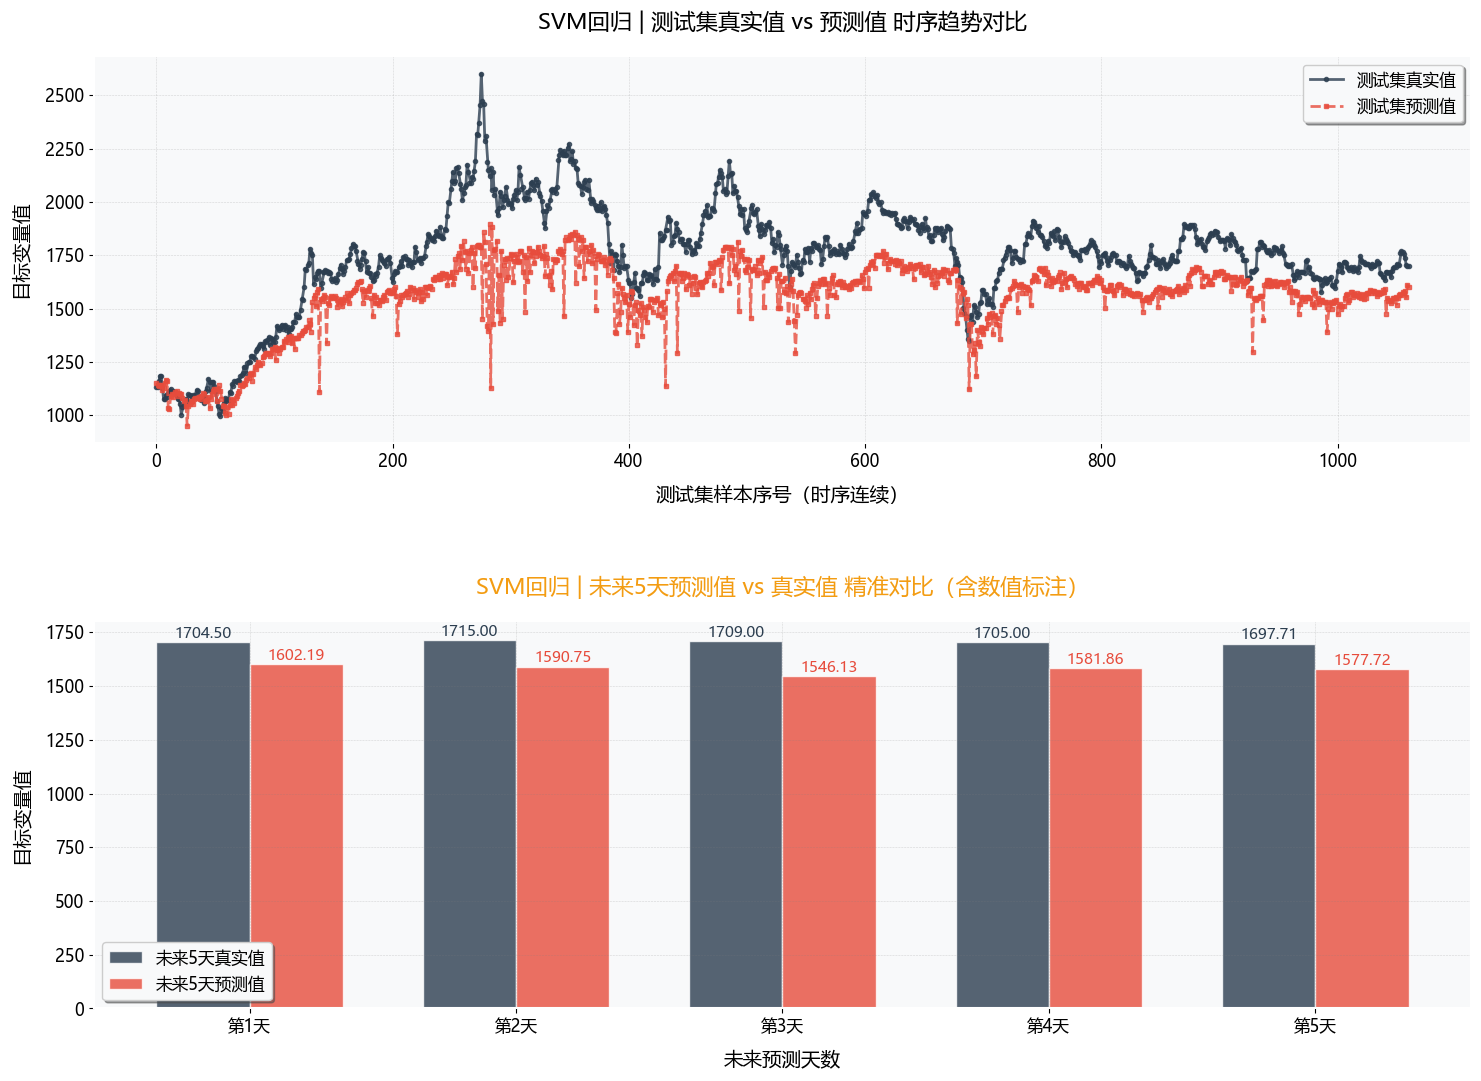


未来5天真实值vs预测值详细对比：
           未来天数      真实值      预测值    绝对误差
Date                                     
2024-05-09  第1天  1704.50  1602.19  102.31
2024-05-10  第2天  1715.00  1590.75  124.25
2024-05-13  第3天  1709.00  1546.13  162.87
2024-05-14  第4天  1705.00  1581.86  123.14
2024-05-15  第5天  1697.71  1577.72  119.99


In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))  
COLOR_TRUE = '#2c3e50'    # 真实值
COLOR_PRED = '#e74c3c'    # 预测值
COLOR_FUTURE = '#f39c12'  # 未来5天
LINE_WIDTH = 2.0
ALPHA = 0.8


x_test = np.arange(len(y_test))
ax1.plot(x_test, y_test, label='测试集真实值', color=COLOR_TRUE, 
         linewidth=LINE_WIDTH, alpha=ALPHA, marker='o', markersize=3)

ax1.plot(x_test, y_test_pred, label='测试集预测值', color=COLOR_PRED, 
         linewidth=LINE_WIDTH, alpha=ALPHA, linestyle='--', marker='s', markersize=3)

ax1.set_title('SVM回归 | 测试集真实值 vs 预测值 时序趋势对比', fontsize=16, pad=20, fontweight='bold')
ax1.set_xlabel('测试集样本序号（时序连续）', fontsize=14, labelpad=10)
ax1.set_ylabel('目标变量值', fontsize=14, labelpad=10)
ax1.legend(loc='best', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax1.grid(True, color='gray', alpha=0.3)
ax1.tick_params(axis='both', labelsize=12)  # 调整刻度字体大小


x_future = np.arange(1, 6)
bar_width = 0.35
ax2.bar(x_future - bar_width/2, future_5_y_true, bar_width, 
         label='未来5天真实值', color=COLOR_TRUE, alpha=ALPHA, edgecolor='white', linewidth=1)
ax2.bar(x_future + bar_width/2, future_5_y_pred, bar_width, 
         label='未来5天预测值', color=COLOR_PRED, alpha=ALPHA, edgecolor='white', linewidth=1)

for i, (true_val, pred_val) in enumerate(zip(future_5_y_true, future_5_y_pred)):
    ax2.text(x_future[i] - bar_width/2, true_val + 1, f'{true_val:.2f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color=COLOR_TRUE)
    ax2.text(x_future[i] + bar_width/2, pred_val + 1, f'{pred_val:.2f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color=COLOR_PRED)

ax2.set_title('SVM回归 | 未来5天预测值 vs 真实值 精准对比（含数值标注）', 
              fontsize=16, pad=20, fontweight='bold', color=COLOR_FUTURE)
ax2.set_xlabel('未来预测天数', fontsize=14, labelpad=10)
ax2.set_ylabel('目标变量值', fontsize=14, labelpad=10)
ax2.set_xticks(x_future)  # 固定x轴刻度为1-5天
ax2.set_xticklabels([f'第{i}天' for i in x_future], fontsize=12)
ax2.legend(loc='best', fontsize=12, frameon=True, shadow=True, fancybox=True)
ax2.grid(True, axis='y', color='gray', alpha=0.3)  # 仅显示y轴网格，更清晰
ax2.tick_params(axis='y', labelsize=12)


plt.tight_layout(pad=5.0)
plt.show()

future_compare = pd.DataFrame({
    '未来天数': [f'第{i}天' for i in range(1,6)],
    '真实值': future_5_y_true.round(2),
    '预测值': future_5_y_pred.round(2),
    '绝对误差': np.abs(future_5_y_true - future_5_y_pred).round(2)
})
print("\n未来5天真实值vs预测值详细对比：")
print(future_compare)

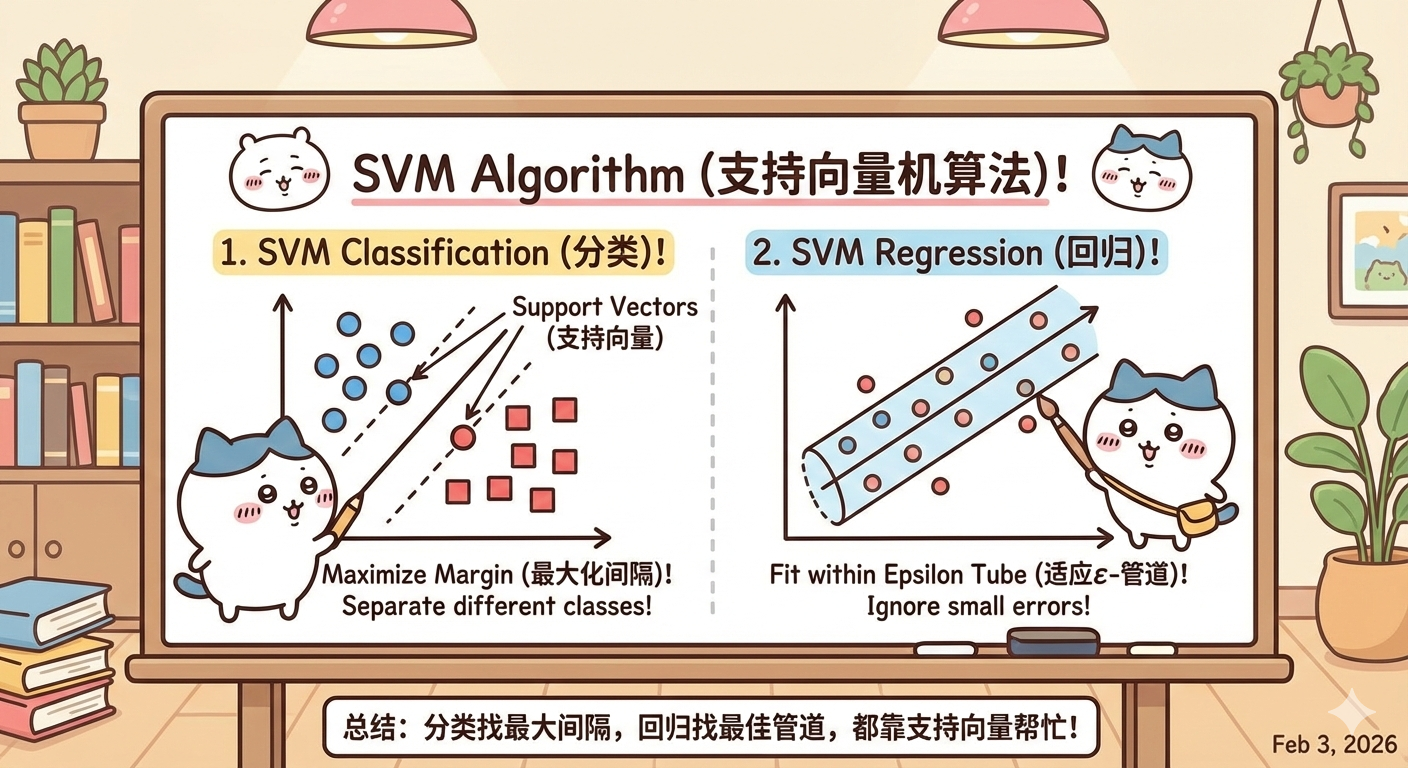